# Выявление факторов успешности компьютерных игр

## Описание
Интернет магазину компьютерных игр для оптимизации продуктовой линейки и планирования рекламных компаний необходимо определить факторы и закономерности, определяющие успешность игр.


Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

## Содержание

1. [Предобработка данных.](#1)
2. [Исследовательский анализ данных.](#2)
3. [Проверка статистических гипотез.](#3)
4. [Общие выводы.](#4)

# 1. Предобработка данных. <a id=1></a>

### Знакомство с данными

In [116]:
# импортируем все, что пригодится
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [117]:
# Забираем сет  и осматриваем данные
df = pd.read_csv('games.csv')
df.info()
df.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.1+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Предварительно, следующие роблемы в данных:
1. Пропуски в колонках     
Name              
Year_of_Release    
Genre              
Critic_Score       
User_Score         
Rating             
2. Year_of_Release лучше привести к типу целых чисел
3. Колонка User_Score имеет класс object (из-за вкрапления текстовых значений)


### Подготовка данных

In [118]:
# Заменим регистр в названиях колонок дляудобства обработки
df.columns=df.columns.str.lower()
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


In [119]:
# Сменим регистр в колонках name, platform и genre на нижний
df['name'] = df['name'].str.lower() 
df['platform'] = df['platform'].str.lower()
df['genre'] = df['genre'].str.lower()
#df.head(3)

# и найдем явные дубликаты
df.duplicated().sum()
# явные дубликаты отсутствуют

0

### Ликвидация пропусков

In [120]:
# посмотрим как распределены данные по годам
df['year_of_release'].value_counts()

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      62
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: year_of_release, dtype: int64

<span style='color:blue'>Количество игр до 2000г. и игр с неизвестной датой релиза всего около 13% датасета. Это не мало, но индустрия игр так сильно преобразилась с 1980-х, что закономерности периода до 2000г могут скорее внести искажения в те закономерности, которые наблюдаются в текущий момент. Т.е. ценность этих данных сомнительна. Кроме того, Выделение игр от 2000 года позволит сразу решить часть проблем с пропусками, которые наблюдаются в данных ранних лет. </span>

In [121]:
# посмотрим какие проблемы удастся решить обрезав данные по 2000 г.
df.query('year_of_release >= 2000').info()
# остались пропуски только в трех рейтинговых колонках

# обрезаем сет до актуального периода
df = df.query('year_of_release >= 2000')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14470 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14470 non-null  object 
 1   platform         14470 non-null  object 
 2   year_of_release  14470 non-null  float64
 3   genre            14470 non-null  object 
 4   na_sales         14470 non-null  float64
 5   eu_sales         14470 non-null  float64
 6   jp_sales         14470 non-null  float64
 7   other_sales      14470 non-null  float64
 8   critic_score     7887 non-null   float64
 9   user_score       9738 non-null   object 
 10  rating           9663 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.0+ MB


<span style='color:blue'>Выделение актуального периода позволило попутно решить часть проблем с пропусками. Остались только пропуски в рейтинговых колонках critic_score, user_score, rating. Пропуски в этих колонках не помешают обработке данных. При этом, около 87% наиболее актуальных данных сохранено.</span>

### Преобразование типов данных

In [122]:
# определим значения, которые превращают колонку user_score в тип object
print('Подсчет значений user_score: \n', df['user_score'].value_counts(),'\n')
# значение tbd (to be determined) означает, что на данный момент значение еще не определено(фактически отсутствует)

# раз значение фактически отсутствует, а пропуски в этой колонке мы оставили без заполнения,то логично сбросить и значения tbd
df.loc[df['user_score'] == 'tbd', 'user_score'] = ''
df['user_score'] = pd.to_numeric(df['user_score'])
print('Подсчет значений user_score после сброса: \n', df['user_score'].value_counts())

Подсчет значений user_score: 
 tbd    2367
7.8     319
8       284
8.2     270
8.3     247
       ... 
0.3       2
1.3       2
0.5       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64 

Подсчет значений user_score после сброса: 
 7.8    319
8.0    284
8.2    270
8.3    247
7.5    246
      ... 
0.9      2
1.1      2
2.3      2
0.0      1
9.7      1
Name: user_score, Length: 95, dtype: int64


In [123]:
#для удобства преведем year_of_release  к типу целых чисел
df['year_of_release'] = df['year_of_release'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14470 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14470 non-null  object 
 1   platform         14470 non-null  object 
 2   year_of_release  14470 non-null  int32  
 3   genre            14470 non-null  object 
 4   na_sales         14470 non-null  float64
 5   eu_sales         14470 non-null  float64
 6   jp_sales         14470 non-null  float64
 7   other_sales      14470 non-null  float64
 8   critic_score     7887 non-null   float64
 9   user_score       7371 non-null   float64
 10  rating           9663 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.0+ MB


### Расчет производных данных

In [124]:
# Посчитаем суммарные продажи
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
#df['sum_sales']

#  2. Исследовательский анализ данных. <a id=2></a>

### Общерыночные тенденции

Text(0.5, 1.0, 'Динамика выпуска игр по годам \n')

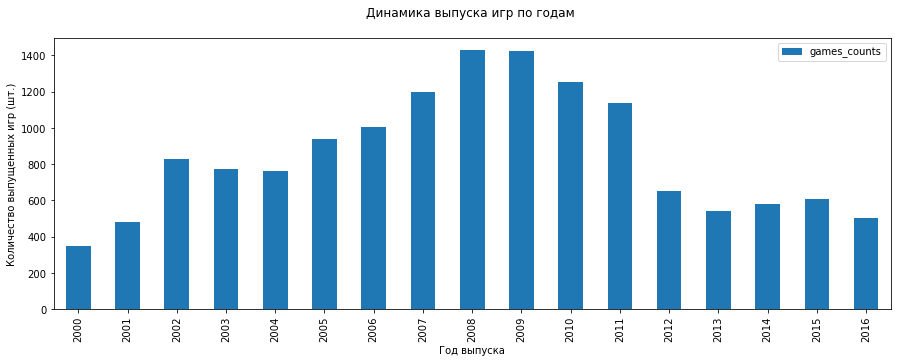

In [125]:
# Начнем с общерыночных тенденций

# Как много игр выпущено в разные годы?
years_counts = pd.DataFrame(df['year_of_release'].value_counts()).reset_index().sort_values(by='index')
years_counts.columns = ['year_of_release','games_counts'] 
years_counts.plot(x = 'year_of_release', y = 'games_counts', figsize=(15,5), kind='bar')
plt.ylabel('Количество выпущенных игр (шт.)')
plt.xlabel('Год выпуска')
plt.title('Динамика выпуска игр по годам \n')


<span style='color:Blue'>Количесво игр выводимых на рынок достигло пика в 2008г. С тех пор оно сократилось более чем вдвое.  </span>

Text(0.5, 1.0, 'Динамика продаж игр по годам \n')

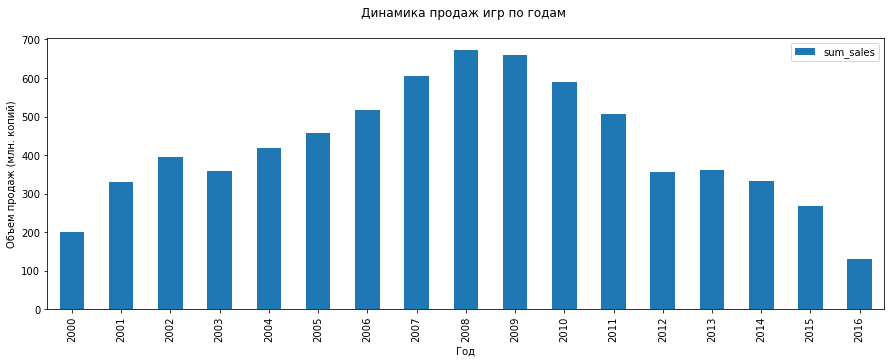

In [126]:
# Каковы общие объемы продаж по годам?
years_sales = df.pivot_table(index='year_of_release', values='sum_sales', aggfunc='sum').reset_index()
years_sales.plot(x = 'year_of_release', y = 'sum_sales', figsize=(15,5),kind='bar')
plt.ylabel('Объем продаж (млн. копий)')
plt.xlabel('Год')
plt.title('Динамика продаж игр по годам \n')

<span style='color:Blue'>Объем продаж так же сократился с пика в 2008г. Т.е. покупатели не перераспределились между сократившимся количеством игр, а стали меньше их покупать.</span>

Text(0.5, 1.0, 'Динамика продаж игр на различных территориальных рынках \n')

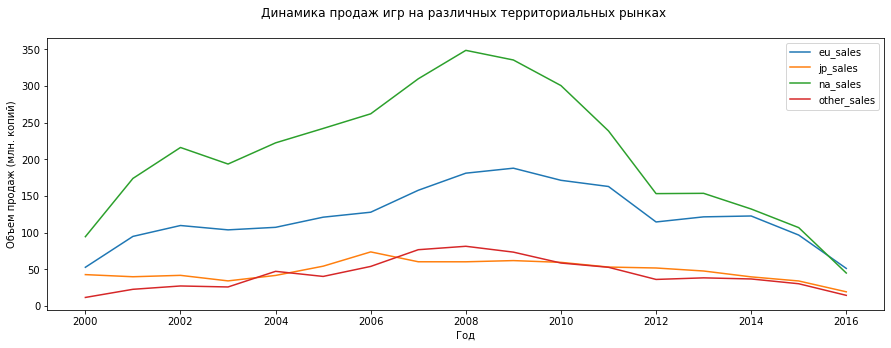

In [127]:
# посмотрим на продажи в разрезе территориальных рынков
markets_sales = df.pivot_table(index='year_of_release', values=('na_sales','eu_sales','jp_sales','other_sales'), aggfunc='sum').reset_index()


ax = markets_sales.plot(x = 'year_of_release', y = 'eu_sales')
markets_sales.plot(x = 'year_of_release', y = 'jp_sales', figsize=(15,5), ax=ax)
markets_sales.plot(x = 'year_of_release', y = 'na_sales',ax=ax)
markets_sales.plot(x = 'year_of_release', y = 'other_sales',ax=ax)
plt.ylabel('Объем продаж (млн. копий)')
plt.xlabel('Год')
plt.title('Динамика продаж игр на различных территориальных рынках \n')


<span style='color:Blue'> Картина по территориальным рынкам в целом идентична. Сжатие рынка примерно с 2008г. Хотя, данные за 20016г. могут быть не полными, общая тенденция очевидна и без них.</span>

### Взаимосвязь оценк пользователей и критиков с объемами продаж

In [128]:
# определим корреляцию оценок пользователей и объемов продаж
df['sum_sales'].corr(df['user_score'])
# очень слабая корреляция

0.08102004419140847

In [129]:
# определим корреляцию оценок критиков и объемов продаж
df['sum_sales'].corr(df['critic_score'])
# чуть сильнее, но так же очень слабая корреляция

0.2381650578416602

Text(0.5, 1.0, 'Зависимость объемов продаж от оценки критиков \n')

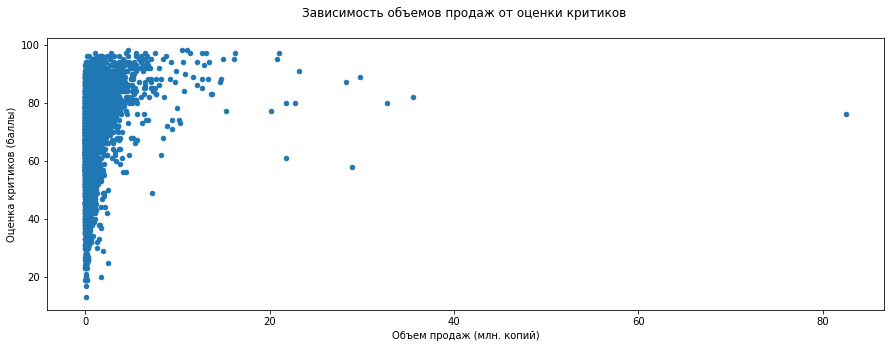

In [130]:
# Корреляция оценок критиков и объемов продаж  чуть сильнее. Посмотрим ее на графике.
df.plot(x='sum_sales', y='critic_score', kind='scatter', figsize=(15,5))
plt.ylabel('Оценка критиков (баллы)')
plt.xlabel('Объем продаж (млн. копий)')
plt.title('Зависимость объемов продаж от оценки критиков \n')

<span style='color:Blue'>Ни оценки критиков, ни оценки пользователей не имеют однозначной связи с объемом продаж, а значит ориентироваться на этот показатель в первую очередь не стоит, но как фактор второго порядка, оценка критиков имеет право на существование.</span>

<br><span style='color:Blue'>График продемонстрировал одно выдающееся значение по объему продаж, на столько большое, что оно способно существенно исказить дальнейшее исследование по платформам в случае, если это ошибка.</span>

In [131]:
# попробуем разобраться с выдающимся значением на предыдущем графике
df[df['sum_sales'] > 60]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54


"Википедия     

wii sports     

Видеоигра, выпущенная компанией Nintendo для собственной игровой приставки Wii. Игра появилась в продаже вместе с приставкой, кроме того, за исключением Японии, она вложена прямо в коробку с Wii".

<span style='color:Blue'>Хотя в данном случае популярность игры обусловлена скорее популярностью платфоры, к которой она прилагалась, это нельзя назвать ошибкой в полной мере. </span>

### Тенденции по платформам

In [132]:
# Какие платформы представлены и какова их общая популярность?
df['platform'].value_counts()

ps2     2127
ds      2120
ps3     1306
wii     1286
x360    1232
psp     1193
pc       917
gba      811
xb       803
gc       542
3ds      512
psv      429
ps4      392
ps       274
xone     247
wiiu     147
n64       70
dc        31
gb        27
ws         4
Name: platform, dtype: int64

Text(0.5, 1.0, 'Динамика объемов продаж в разрезе игровых платформ \n')

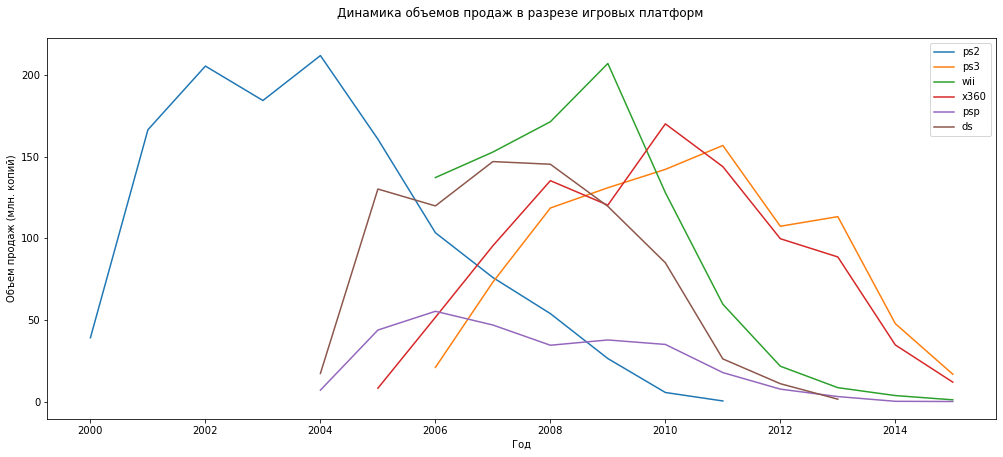

In [133]:
# Посмотрим как менялись продажи по отдельным наиболее популяпным платформам

# сформируем таблицу продаж по годам и платформам
platforms_sales = df.pivot_table(index=('year_of_release','platform'),values='sum_sales', aggfunc='sum').reset_index()

# обрежем 2016г. т.к. данные за него могут быть не полными
platforms_sales = platforms_sales.query('year_of_release < 2016')

ax = platforms_sales.query('platform == "ps2"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='ps2')
platforms_sales.query('platform == "ps3"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='ps3', ax=ax)
platforms_sales.query('platform == "wii"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='wii', ax=ax)
platforms_sales.query('platform == "x360"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='x360', ax=ax)
platforms_sales.query('platform == "psp"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='psp', ax=ax)
platforms_sales.query('platform == "ds"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='ds', ax=ax)
plt.ylabel('Объем продаж (млн. копий)')
plt.xlabel('Год')
plt.title('Динамика объемов продаж в разрезе игровых платформ \n')

<span style='color:Blue'> График наглядно демонстрирует, что все наиболее популярные платформы уже прошли свой пик, и к настоящему моменту не актуальны. Участок жизненного цикла от выхода до пика популярности составляет около 3-5 лет. Соответственно, наиболее перспективные игры стоит искать по платформам с момента выпуска которых прошло не более 2-х лет т.к. в дальнейшем объемы продаж могут существенно упасть. </span>

Text(0.5, 1.0, 'Динамика объемов продаж в разрезе игровых платформ \n')

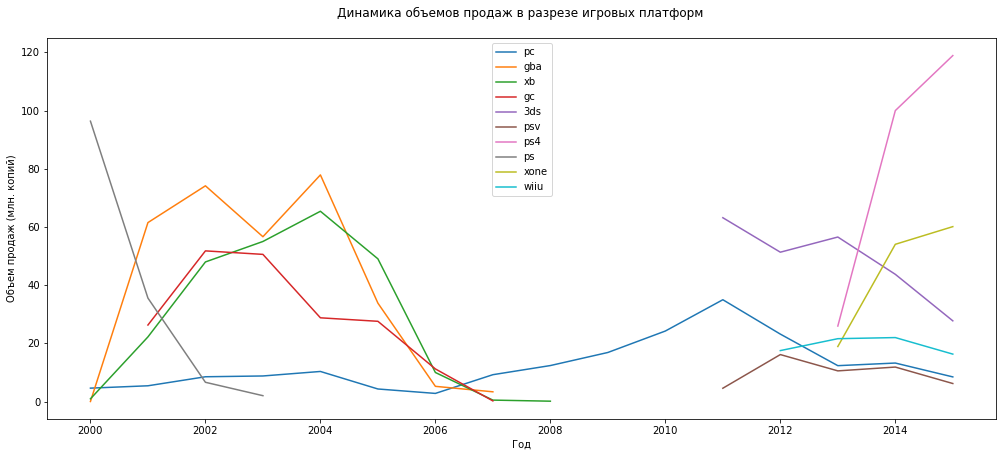

In [134]:
# посмотрим, есть ли растущие платформы, среди оставшихся
ax1 = platforms_sales.query('platform == "pc"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='pc')
platforms_sales.query('platform == "gba"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='gba', ax=ax1)
platforms_sales.query('platform == "xb"').plot(label='xb',x='year_of_release', y='sum_sales', figsize=(17,7),  ax=ax1)
platforms_sales.query('platform == "gc"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='gc', ax=ax1)
platforms_sales.query('platform == "3ds"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='3ds', ax=ax1)
platforms_sales.query('platform == "psv"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='psv', ax=ax1)
platforms_sales.query('platform == "ps4"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='ps4', ax=ax1)
platforms_sales.query('platform == "ps"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='ps', ax=ax1)
platforms_sales.query('platform == "xone"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='xone', ax=ax1)
platforms_sales.query('platform == "wiiu"').plot(x='year_of_release', y='sum_sales', figsize=(17,7), label='wiiu', ax=ax1)
plt.ylabel('Объем продаж (млн. копий)')
plt.xlabel('Год')
plt.title('Динамика объемов продаж в разрезе игровых платформ \n')

<span style='color:Blue'> На этапе роста находятся продажи игр для ps4 и xone(Xbox One). Они и будут фаворитными платформами при выборе игры. Причем у ps4 приоритет из-за бОльших объемов продаж. </span>

<span style='color:Blue'> Стоит обратить особое внимание на то, что 'рс' - personal computer. Жизненный цикл персонального помпьютера нельзя сравнивать с циклом игровых приставок. Продажи игр для ПК всегда относительно малы, но очень стабильны. </span>

<span style='color:Blue'> Последний график наглядно демонстрирует актуальный период для анализа по платформам - примерно последние 3 года. В нашем случае с 2014г. </span>

Text(0.5, 1.0, 'Распределение объемов продаж отдельных игр в разрезе игровых платформ')

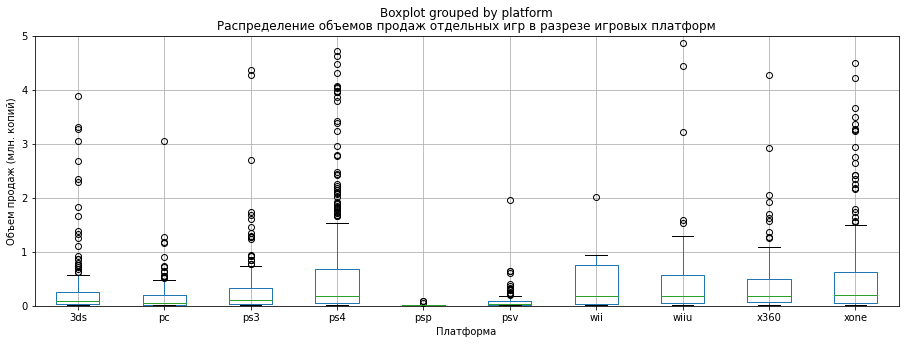

In [135]:
# Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам за последние 5 лет с 2012г.
df.query('year_of_release >= 2014').boxplot(column='sum_sales', by='platform', figsize=(15,5))
plt.ylim(0, 5)
plt.ylabel('Объем продаж (млн. копий)')
plt.xlabel('Платформа')
plt.title('Распределение объемов продаж отдельных игр в разрезе игровых платформ')

<span style='color:Blue'> Среди лидеров продаж за последние 5 лет в диаграмме размаха находятся и растущие(ps4, XOne)и уходящие(ps3, x360, wii)уходящие платформы. Это еще раз подчеркивает необходимость учитывать этап жизненного цикла платформы при выборе игры. </span>

<span style='color:Blue'> Продажи по платформам сильно скошены в большую сторону относительно средних значений. Это значит, что есть большой набор игр сильно выделяющихся объемами продаж. По всем платформам основной объем игр продается в пределах 2 млн. экз., но есть выдающиеся. Возможно, стоит поискать характерные черты этих выдающихся игр.</span>

0.3945748380247344

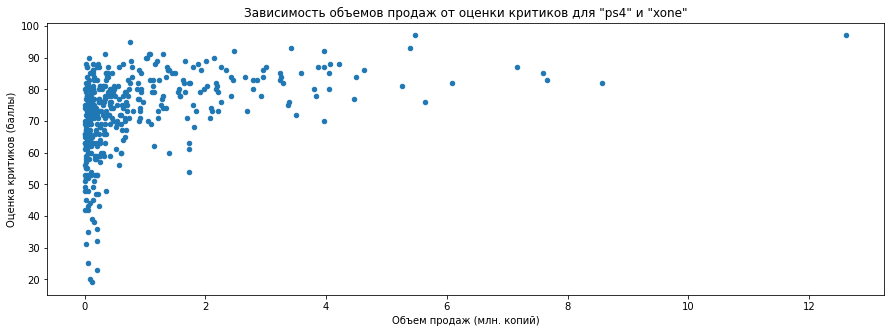

In [136]:
# Попробуем выяснить, есть ли связь между отзывами и продажами для наиболее перспективных платформ: ps4, XOne.

#сначала для оценок критиков
df.query('platform == "ps4" or platform == "xone"').plot(x='sum_sales', y='critic_score', kind='scatter', figsize=(15,5))
plt.ylabel('Оценка критиков (баллы)')
plt.xlabel('Объем продаж (млн. копий)')
plt.title('Зависимость объемов продаж от оценки критиков для "ps4" и "xone"')

# Оценим корреляцию
df.query('platform == "ps4" or platform == "xone"')['sum_sales'].corr(df.query('platform == "ps4" or platform == "xone"')['critic_score'])


<span style='color:Blue'> Высокий рейтинг не гарантирует хороших продаж, но дает на них шанс. Лучше не выбирать для продажи игры с рейтингом ниже 60 </span>

-0.035968225477893745

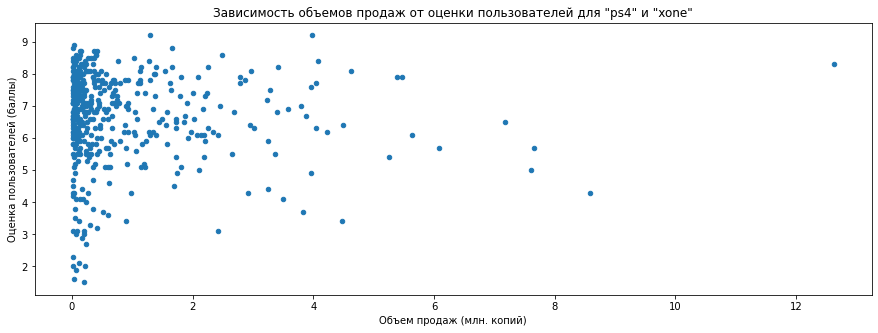

In [137]:
# теперь для оценок пользователей
df.query('platform == "ps4" or platform == "xone"').plot(x='sum_sales', y='user_score', kind='scatter', figsize=(15,5))
plt.ylabel('Оценка пользователей (баллы)')
plt.xlabel('Объем продаж (млн. копий)')
plt.title('Зависимость объемов продаж от оценки пользователей для "ps4" и "xone"')

# оценим корреляцию
df.query('platform == "ps4" or platform == "xone"')['sum_sales'].corr(df.query('platform == "ps4" or platform == "xone"')['user_score'])

<span style='color:Blue'> Связь практически отсутствует. С оценкой выше 3 баллов уже есть шанс получить отличные продажи. Оценка пользователей -  последнее, на что можно обращать внимание. </span>

<span style='color:Blue'> Ситуация по связи продаж с оценками пользователей и критиков соответствует на перспективных платформах ps4, XOne и по рынку в целом. </span>

### Тенденции по жанрам

 
Что можно сказать о самых прибыльных жанрах? 
Выделяются ли жанры с высокими и низкими продажами?
Есть ли у жанра жизненный цикл?

In [138]:
# Посмотрим на общее распределение выпущенных игр по жанрам c 2014г.
genres_production = pd.DataFrame(df.query('year_of_release >= 2014')['genre'].value_counts()).reset_index()
genres_production.columns = ['genre','games_counts']
genres_production

,genre,games_counts
0,action,619
1,role-playing,221
2,adventure,185
3,sports,161
4,shooter,128
5,misc,113
6,racing,69
7,fighting,60
8,simulation,44
9,platform,38


<span style='color:Blue'> Самые популярные игры среди разработчиков:     
action          
role-playing    
adventure       
sports          
shooter   </span>

In [139]:
# Сформируем данные по жанрам и годам
genres_data = df.pivot_table(index=('year_of_release','genre'), values='sum_sales', aggfunc='sum').reset_index()

# Обрежем период теми же актуальными сроками, которые были выявлены на данных о платформах
genres_data = genres_data.query('year_of_release >= 2014').reset_index(drop=True)
#genres_data.head()

# Посмотрим на общее распределение продаж по жанрам.
genres_consumption = genres_data.pivot_table(index='genre', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False).reset_index()
genres_consumption

,genre,sum_sales
0,action,199.36
1,shooter,170.94
2,sports,109.48
3,role-playing,101.44
4,misc,37.55
5,fighting,28.22
6,racing,27.52
7,platform,18.09
8,adventure,17.55
9,simulation,13.13


<span style='color:Blue'> Самые большие объемы продаж в жанрах:     
action   
shooter    
sports    
role-playing        
fighting 	
racing         
Видим что данные по предпочтениям разработчиков и потребителей не совсем совпадают.
   </span>

<span style='color:Blue'>     
В списке выше намеренно не указан misc, т.к. это не жанр, а общее обозначение для всех внежанровых игр.
</span>

<span style='color:Blue'>     
Проблема определения продаваемости жанров заключается в том, что количество игр выпущенных для данного жанра может влиять на суммарный объем продаж. Для определения наиболее привлекательных жанров было бы неплохо дополнительно понимать сколько продаж пришлось в среднем на одну игру данного жанра.
</span>

In [140]:
# Объеденим таблицы с количеством выпущенных и проданных игр по жанру.
genres_metrics = genres_production.merge(genres_consumption)

# Посчитаем средние продажи на каждую игру данного жанра
genres_metrics['sales_by_game'] = genres_metrics['sum_sales'] / genres_metrics['games_counts']
genres_metrics.sort_values(by='sales_by_game', ascending=False)

,genre,games_counts,sum_sales,sales_by_game
4,shooter,128,170.94,1.335469
3,sports,161,109.48,0.680000
9,platform,38,18.09,0.476053
7,fighting,60,28.22,0.470333
1,role-playing,221,101.44,0.459005
6,racing,69,27.52,0.398841
5,misc,113,37.55,0.332301
0,action,619,199.36,0.322068
8,simulation,44,13.13,0.298409
11,puzzle,14,2.21,0.157857


<span style='color:Blue'>     
В расчете на одну игру, наибольшие шансы на хорошие продажи оказались у шутеров и спортивных игр. Заметим, что игры action оказались далеко позади. Вероятно, это связано с тем, что их выпуск почти в три раза больше, чем у ближайшего конкурента, и далеко не все они имеют хорошие продажи. Для нас это значит, что выбирая для продажи конкретную игру, к action нужно относиться с осторожностью из-за большой конкуренции в жанре. Учитывая, что игр shooter выпускается почти в 5 раз меньше чем action, а по совокупным продажам они занимают второе место, то жанр shooter выглядит наиболее предпочтительным.
</span>

### Портрет пользователя по регионам (NA, EU, JP)

In [141]:
#Самые популярные платформы Северной Америки(топ-5)

# Сформируем данные по продажам в NA с 2014г. по платформам
na_sales_by_platform = df.query('year_of_release >= 2014').pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
na_sales_by_platform = na_sales_by_platform.sort_values(by='na_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
na_sales_sum = na_sales_by_platform['na_sales'].sum()
na_sales_by_platform['proportion'] = na_sales_by_platform['na_sales'] / na_sales_sum 
print('Самые популярные платформы Северной Америки(топ-5):')
display(na_sales_by_platform.head())


#Самые популярные платформы Европы(топ-5)

# Сформируем данные по продажам в EU с 2014г. по платформам
eu_sales_by_platform = df.query('year_of_release >= 2014').pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
eu_sales_by_platform = eu_sales_by_platform.sort_values(by='eu_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
eu_sales_sum = eu_sales_by_platform['eu_sales'].sum()
eu_sales_by_platform['proportion'] = eu_sales_by_platform['eu_sales'] / eu_sales_sum 
print('Самые популярные платформы Европы:')
display(eu_sales_by_platform.head())


#Самые популярные платформы Японии(топ-5)

# Сформируем данные по продажам в JP с 2014г. по платформам
jp_sales_by_platform = df.query('year_of_release >= 2014').pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
jp_sales_by_platform = jp_sales_by_platform.sort_values(by='jp_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
jp_sales_sum = jp_sales_by_platform['jp_sales'].sum()
jp_sales_by_platform['proportion'] = jp_sales_by_platform['jp_sales'] / jp_sales_sum 
print('Самые популярные платформы Японии:')
display(jp_sales_by_platform.head())

Самые популярные платформы Северной Америки(топ-5):


,platform,na_sales,proportion
0,ps4,98.61,0.347145
1,xone,81.27,0.286102
2,x360,28.30,0.099627
3,3ds,22.64,0.079701
4,ps3,22.05,0.077624


Самые популярные платформы Европы:


,platform,eu_sales,proportion
0,ps4,130.04,0.480420
1,xone,46.25,0.170866
2,ps3,25.54,0.094355
3,pc,17.97,0.066388
4,3ds,16.12,0.059554


Самые популярные платформы Японии:


,platform,jp_sales,proportion
0,3ds,44.24,0.475239
1,ps4,15.02,0.161349
2,psv,14.54,0.156193
3,ps3,11.22,0.120529
4,wiiu,7.31,0.078526


<span style='color:Blue'> Основная доля продаж игр в Северной Америке и в Европе приходится на платформы ps4 и XOne. При этом доля ps4 в Европе значительно выше.

    
<span style='color:Blue'> Рынок Японии обладает сильной спецификой. Лидирующие позиции на нем c большим отрывом занимают игры для портативной игровой консоли Nintendo 3DS. PS4 занимает лишь второе место, а XOne вообще не представлена в пятерке лидеров.

In [142]:
#Самые популярные жанры Северной Америки(топ-5)

# Сформируем данные по продажам в NA с 2014г. по жанрам
na_sales_by_genre = df.query('year_of_release >= 2014').pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
na_sales_by_genre = na_sales_by_genre.sort_values(by='na_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
na_sales_sum = na_sales_by_genre['na_sales'].sum()
na_sales_by_genre['proportion'] = na_sales_by_genre['na_sales'] / na_sales_sum 
print('Самые популярные жанры Северной Америки(топ-5):')
display(na_sales_by_genre.head())


#Самые популярные жанры Европы(топ-5)

# Сформируем данные по продажам в EU с 2014г. по жанрам
eu_sales_by_genre = df.query('year_of_release >= 2014').pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
eu_sales_by_genre = eu_sales_by_genre.sort_values(by='eu_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
eu_sales_sum = eu_sales_by_genre['eu_sales'].sum()
eu_sales_by_genre['proportion'] = eu_sales_by_genre['eu_sales'] / eu_sales_sum 
print('Самые популярные жанры Европы:')
display(eu_sales_by_genre.head())


#Самые популярные жанры Японии(топ-5)

# Сформируем данные по продажам в JP с 2014г. по жанрам
jp_sales_by_genre = df.query('year_of_release >= 2014').pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
jp_sales_by_genre = jp_sales_by_genre.sort_values(by='jp_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
jp_sales_sum = jp_sales_by_genre['jp_sales'].sum()
jp_sales_by_genre['proportion'] = jp_sales_by_genre['jp_sales'] / jp_sales_sum 
print('Самые популярные жанры Японии:')
display(jp_sales_by_genre.head())

Самые популярные жанры Северной Америки(топ-5):


,genre,na_sales,proportion
0,shooter,79.02,0.278181
1,action,72.53,0.255333
2,sports,46.13,0.162395
3,role-playing,33.47,0.117827
4,misc,15.05,0.052982


Самые популярные жанры Европы:


,genre,eu_sales,proportion
0,action,74.68,0.275898
1,shooter,65.52,0.242057
2,sports,45.73,0.168945
3,role-playing,28.17,0.104071
4,racing,14.13,0.052202


Самые популярные жанры Японии:


,genre,jp_sales,proportion
0,role-playing,31.16,0.334730
1,action,29.58,0.317757
2,fighting,6.37,0.068428
3,misc,5.61,0.060264
4,shooter,4.87,0.052315


<span style='color:Blue'> Распределение по долям продаж в различных жанрах в Европе и Северной Америке почти идентично.
    
<span style='color:Blue'> Рынок Японии в случае с жанрами так же специфичен. Лидером рынка являются игры role-playing(RPG). Это может быть отчасти связано с доминированием в Японии карманного типа платформы (3ds), которая хорошо сочетается с данным жанром. Еще одно существенное отличие рынка - слабая популярность шутеров. Рынок Японии более сконцентрирован. Два первыхжанра занимают более 60% продаж.

In [143]:
#Влияет ли рейтинг ESRB на продажи в отдельном регионе?

# Северная Америка
# Сформируем данные по продажам в NA с 2014г. по рейтингу
na_sales_by_rating = df.query('year_of_release >= 2014').pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
na_sales_by_rating = na_sales_by_rating.sort_values(by='na_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
na_sales_sum = na_sales_by_rating['na_sales'].sum()
na_sales_by_rating['proportion'] = na_sales_by_rating['na_sales'] / na_sales_sum 
print('Популярность рейтингов в Северной Америке:')
display(na_sales_by_rating)


# Европа

# Сформируем данные по продажам в EU с 2014г. по рейтингам
eu_sales_by_rating = df.query('year_of_release >= 2014').pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
eu_sales_by_rating = eu_sales_by_rating.sort_values(by='eu_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
eu_sales_sum = eu_sales_by_rating['eu_sales'].sum()
eu_sales_by_rating['proportion'] = eu_sales_by_rating['eu_sales'] / eu_sales_sum 
print('Популярность рейтингов в Европе:')
display(eu_sales_by_rating.head())


#Япония

# Сформируем данные по продажам в JP с 2014г. рейтингам
jp_sales_by_rating = df.query('year_of_release >= 2014').pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum')

# Отсортируем и перенесем платформы из индексов в отдельную колонку
jp_sales_by_rating = jp_sales_by_rating.sort_values(by='jp_sales', ascending = False).reset_index()

# Посчитаем доли от общего объема продаж по региону в отдельную колонку
jp_sales_sum = jp_sales_by_rating['jp_sales'].sum()
jp_sales_by_rating['proportion'] = jp_sales_by_rating['jp_sales'] / jp_sales_sum 
print('Популярность рейтингов в Японии:')
display(jp_sales_by_rating.head())

Популярность рейтингов в Северной Америке:


,rating,na_sales,proportion
0,M,96.42,0.439592
1,E,50.74,0.231330
2,T,38.95,0.177578
3,E10+,33.23,0.151500


Популярность рейтингов в Европе:


,rating,eu_sales,proportion
0,M,93.44,0.441317
1,E,58.06,0.274217
2,T,34.07,0.160912
3,E10+,26.16,0.123554


Популярность рейтингов в Японии:


,rating,jp_sales,proportion
0,T,14.78,0.408400
1,E,8.94,0.247030
2,M,8.01,0.221332
3,E10+,4.46,0.123238


<span style='color:Blue'> Рынок Японии снова демонстрирует специфику. В то время как в Северной Америке и Европе игры для взрослых занимают первое место, а игры для подростков третье, в Японии ровно наоборот, игры для подростков значительно более популярны.

0.3482156241875802

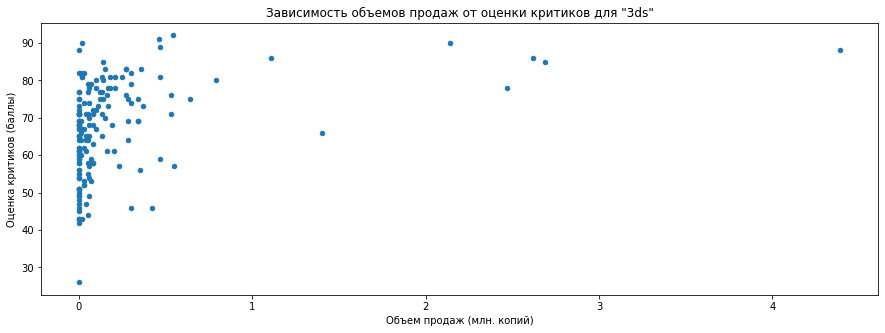

In [144]:
# Раз рынок японии имеет свою доминирующую платформу 3ds попробуем дополнительно определить взаимосвязь
#оценок пользователей и критиков с продажами в японии для игр данной консоли.

#сначала для оценок критиков
df.query('platform == "3ds"').plot(x='jp_sales', y='critic_score', kind='scatter', figsize=(15,5))
plt.ylabel('Оценка критиков (баллы)')
plt.xlabel('Объем продаж (млн. копий)')
plt.title('Зависимость объемов продаж от оценки критиков для "3ds"')

# оценим корреляцию
df.query('platform == "3ds"')['jp_sales'].corr(df.query('platform == "3ds"')['critic_score'])

<span style='color:Blue'> Связь для 3ds в японии между продажами и оценками критиков чуть сильнее, чем для ps4 и XOne на глобальном рынке. В случае ориентации продаж на рынок японии целесообразно поднять критерий отбора до 70 баллов.

0.2726596441307417

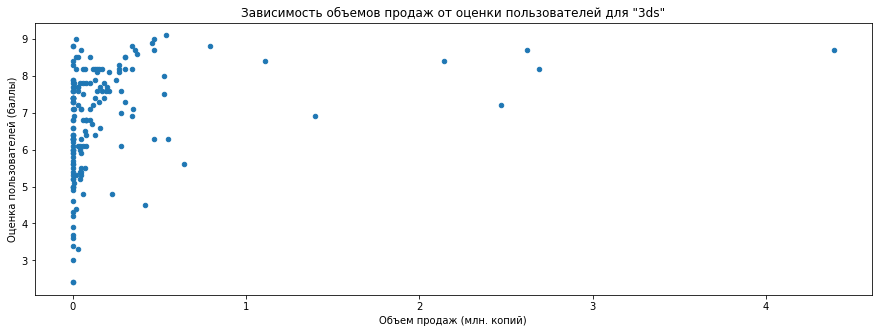

In [145]:
#теперь для оценок пользователей
df.query('platform == "3ds"').plot(x='jp_sales', y='user_score', kind='scatter', figsize=(15,5))
plt.ylabel('Оценка пользователей (баллы)')
plt.xlabel('Объем продаж (млн. копий)')
plt.title('Зависимость объемов продаж от оценки пользователей для "3ds"')

# оценим корреляцию
df.query('platform == "3ds"')['jp_sales'].corr(df.query('platform == "3ds"')['user_score'])

<span style='color:Blue'> В отличие от глобального рынка и платформ  ps4 и XOne, японцы похоже действительно ориентируются на рейтинги при покупке игр для 3ds. В случае опиентации продаж на рынок Японии целесообразно установить критерий пользовательского рейтинга не ниже 6

<span style='color:Blue'> В итоге по портрету потребителя рынки Европы и Северной америки будут совпадать. Типичный игрок этих рынков предпочитает ps4 или XOne и играет в достаточно жесткие игры («Mature» — «Для взрослых») в жанрах action или shooter. Японский потребитель отличается. Для него типичны карманная приставка и PRG игры с подростковым возрастным ограничением.

# 3. Проверка статистических гипотез.  <a id=3></a>

#### Гипотеза №1
#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую и альтернативную гипотезы:    
    H0: Средний пользовательский рейтинг генеральной совокупности игр на платформе Xbox One равен среднему пользовательскому рейтингу генеральной совокупности игр на платформе PC    
    H1: Средний пользовательский рейтинг генеральной совокупности игр на платформе Xbox One не равен среднему пользовательскому рейтингу генеральной совокупности игр на платформе PC

In [146]:
# Применим критерий Стьюдента

# определим выборки данных 
xone_user_score = df.query('platform == "xone"')['user_score'].dropna().reset_index(drop=True)
pc_user_score = df.query('platform == "pc"')['user_score'].dropna().reset_index(drop=True)

# определим значимость и проверим гипотезу
alpha = .05 # раз речь не о жизни или смерти, то 5% допустимый уровень риска ошибки


# рассчитаем результат
results = st.ttest_ind(xone_user_score, pc_user_score)

print('Статистическая значимость разницы между средними значениями рейтинга:',results.pvalue)

if results.pvalue < alpha:
    print('Принимаем нулевую гипотезу. Вероятнее всего, пользователи в среднем одинаово оценивают игры для Xbox One и PC')
else:
    print('Отвергаем нулевую гипотезу. Вероятнее всего, средняя оценка игр для Xbox One и PC пользователями отличается')


Статистическая значимость разницы между средними значениями рейтинга: 3.750185722417337e-05
Принимаем нулевую гипотезу. Вероятнее всего, пользователи в среднем одинаово оценивают игры для Xbox One и PC


#### Гипотеза №2
#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформулируем нулевую и альтернативную гипотезы:    
    H0: Средний пользовательский рейтинг генеральной совокупности игр в жанре Action равен среднему пользовательскому рейтингу генеральной совокупности игр в жанре Sports   
    H1: Средний пользовательский рейтинг генеральной совокупности игр в жанре Action не равен среднему пользовательскому рейтингу генеральной совокупности игр в жанре Sports
        
        В данном случае, гипотеза №2 будет соответствовать альтернативной.

In [147]:
# Применим критерий Стьюдента

# определим выборки данных 
action_user_score = df.query('genre == "action"')['user_score'].dropna().reset_index(drop=True)
sports_user_score = df.query('genre == "sports"')['user_score'].dropna().reset_index(drop=True)

# определим значимость и проверим гипотезу
alpha = .05 # раз речь не о жизни или смерти, то 5% допустимый уровень риска ошибки


# рассчитаем результат
results = st.ttest_ind(action_user_score, sports_user_score)

print('Статистическая значимость разницы между средними значениями рейтинга:',results.pvalue)

if results.pvalue < alpha:
    print('Принимаем нулевую гипотезу. Вероятнее всего, пользователи в среднем одинаово оценивают игры в жанрах action и sports')
else:
    print('Отвергаем нулевую гипотезу. Вероятнее всего, средняя оценка игр в жанрах action и sports отличается')

Статистическая значимость разницы между средними значениями рейтинга: 0.09063548503578989
Отвергаем нулевую гипотезу. Вероятнее всего, средняя оценка игр в жанрах action и sports отличается


# 4. Общие выводы. <a id=4></a>

В итоге имеем следующие критерии в порядке убывания значимости(за исключением случая ориентации на Японский рынок):
- Предпочтительная платформа - ps4
- Предпочтительный жанр - shooter
- Предпочтительный возрастной рейтинг М («Mature» — «Для взрослых»)
- Оценка критиков не ниже 60 баллов(по 100б шкале )
- Оценка пользователей не ниже 3-х баллов(по 10б шкале)

При ориентации на рынок Японии:
- Предпочтительная платформа - 3ds
- Предпочтительный жанр - role-playing(RPG)
- Предпочтительный возрастной рейтинг T («Teen» — «Для подростков»)
- Оценка критиков не ниже 70 баллов(по 100б шкале )
- Оценка пользователей не ниже 6 баллов(по 10б шкале)
